In [570]:
import cv2
import glob
import numpy as np
from torch.autograd import Variable
import torch.nn as nn

In [571]:
imgs_names = []
target_names = []

In [572]:
# Here we get the names of all the pictures that we are going to be using
for filename in glob.glob('../Research/Shadow/card/train/*.png'):
    imgs_names.append(filename)
    s = ""
    s += filename[0:24] + "gt/" + filename[31:len(filename)]
    target_names.append(s)

In [573]:
imgs = []
target = []

# Loop that read in the images and the target images
for i in range(0, len(imgs_names)):
    imgs.append(cv2.imread(imgs_names[i]))
    target.append(cv2.imread(target_names[i]))

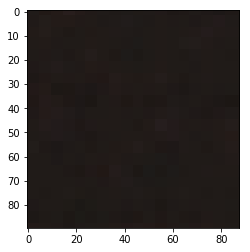

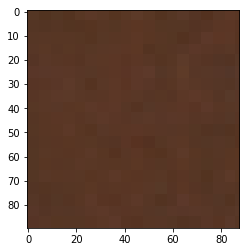

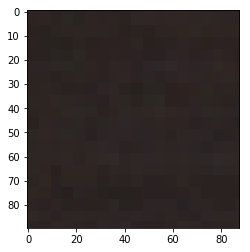

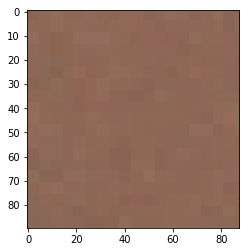

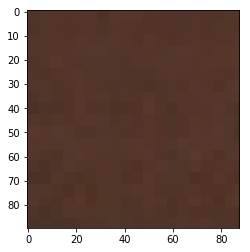

In [574]:
import matplotlib.pyplot as plt

# Output some of the images from the training set
for i in range(0, 5):   
    plt.figure(i)
    plt.imshow(imgs[i])
    
plt.show()


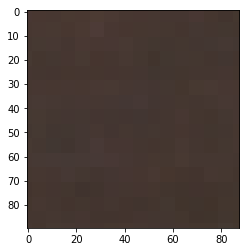

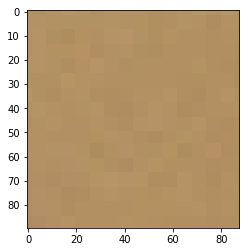

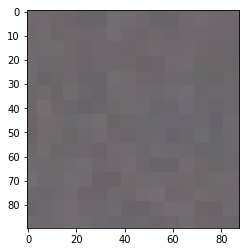

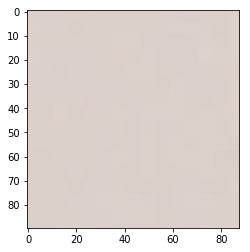

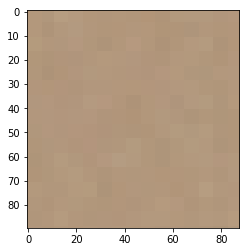

In [575]:
# Output some of the images from the target set
for i in range(0, 5):   
    plt.figure(i)
    plt.imshow(target[i])
    
plt.show()

In [576]:
import torch
# converting the lists into numpy arrays
n_imgs = np.asarray(imgs)/255
n_target = np.asarray(target)/255

# convert the numpy arrays into torch tensors
t_imgs = torch.tensor(np.asarray(n_imgs).reshape(-1, 3)) # this is to do regression on channels
t_target = torch.tensor(np.asarray(n_target).reshape(-1, 3)) # this is to do regression on channels

In [577]:
# Check the sizes of the images
print(t_imgs.size(), t_target.size())
print(n_imgs.shape, n_target.shape)

torch.Size([380160, 3]) torch.Size([380160, 3])
(48, 90, 88, 3) (48, 90, 88, 3)


In [578]:
from torch.utils.data import Dataset, DataLoader

# Create the data class, this is done to load the data into the pytorch model
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = t_imgs.view(-1, 3).float()
        self.y = t_target.float()
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get items
    def __len__(self):
        return self.len

In [579]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.linear(x)
        return self.relu(out)

class SimpleNet(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(SimpleNet, self).__init__()
        
        self.i = nn.Linear(inputSize, 32)
        self.relu1 = nn.ReLU() 
        
        self.h2 = nn.Linear(32, 64)
        self.relu2 = nn.ReLU() 
        
        self.h3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU() 
        
        self.o = nn.Linear(32, outputSize)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        
        output1 = self.i(x)
        output1 = self.relu1(output1)

        output2 = self.h2(output1)
        output2 = self.relu2(output2)

        output3 = self.h3(output2)
        output3 = self.relu3(output3)
        
        output4 = output1 + output3 # skip connection
        
        output = self.o(output4)
#         output = self.relu4(output)
        
        return output

In [580]:
trainloader = DataLoader(dataset=Data(), batch_size=32) # Create the loader for the model 
model = SimpleNet(3, 3) # Initialize the model

In [581]:
# This method is to save the model after a threshold
def save_models(epoch):
    torch.save(model.state_dict(), "reg_model{}.model".format(epoch))
    print("Chekcpoint saved")

In [582]:
# Hyperparameters
learningRate = 1
epochs = 10

In [583]:
criterion = torch.nn.MSELoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate) # Gradient

In [584]:
# Train the model
def train_model(epochs):
    for epoch in range(epochs):  
        for x, y in trainloader:
#             print(x.shape, y.shape)
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             print(yhat[0], y[0])
            
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        if epoch % 10 ==0:
            save_models(epoch)

train_model(10)

epoch 0, loss 9.60308825597167e-05
Chekcpoint saved
epoch 1, loss 9.699659131001681e-05
epoch 2, loss 9.65330982580781e-05
epoch 3, loss 9.522769687464461e-05
epoch 4, loss 9.514021076029167e-05
epoch 5, loss 9.52359041548334e-05
epoch 6, loss 9.546583896735683e-05
epoch 7, loss 9.510118252364919e-05
epoch 8, loss 9.788687020773068e-05
epoch 9, loss 9.734145714901388e-05


In [585]:
with torch.no_grad():
    predicted = model(t_imgs.float()).data.numpy()
    org = t_imgs.numpy()
    res = t_target.numpy()
    print(predicted)


[[0.40299854 0.362003   0.37459412]
 [0.40184513 0.36253253 0.37531263]
 [0.40184513 0.36253253 0.37531263]
 ...
 [0.4316346  0.40258107 0.41877097]
 [0.4316346  0.40258107 0.41877097]
 [0.4306789  0.40733272 0.4258198 ]]


In [586]:
type(t_target.numpy())

numpy.ndarray

In [587]:
predicted = predicted.reshape(48, 90, 88, 3)
org = org.reshape(48, 90, 88, 3)
res = res.reshape(48, 90, 88, 3)

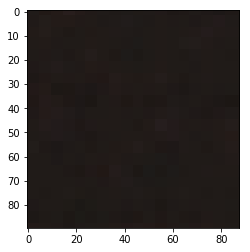

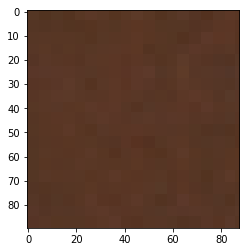

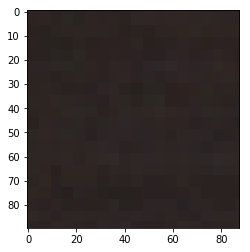

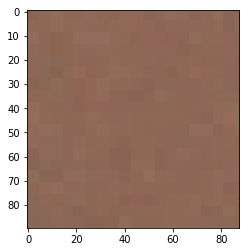

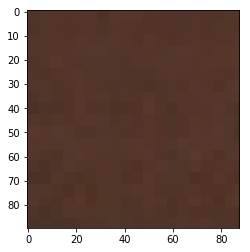

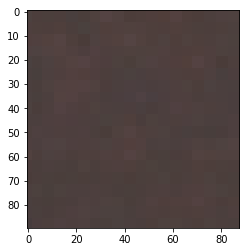

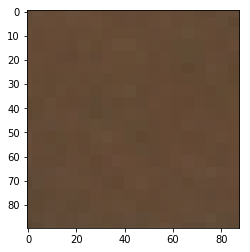

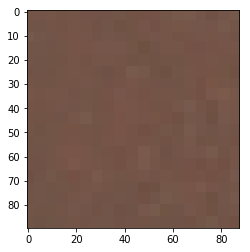

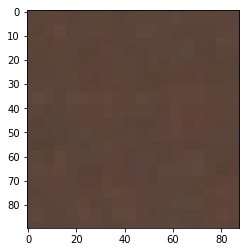

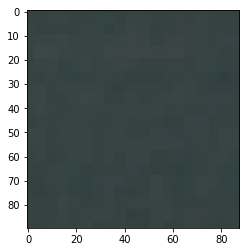

In [588]:
# This output the training images
for i in range(0, 10):   
    plt.figure(i)
    plt.imshow(org[i])
    
plt.show()

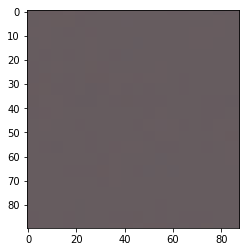

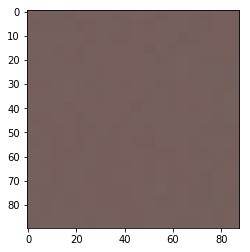

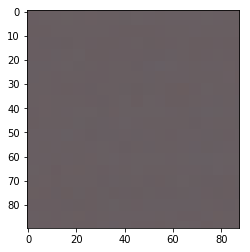

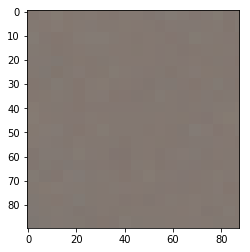

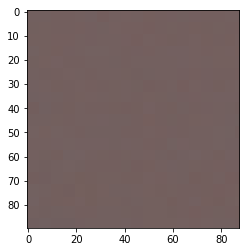

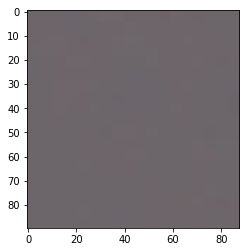

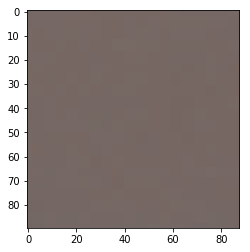

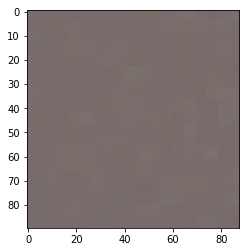

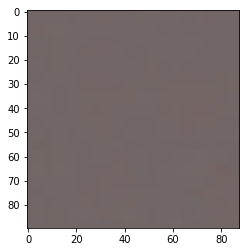

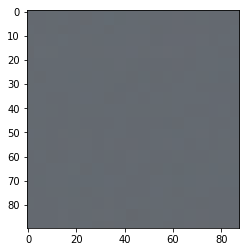

In [589]:
# This output the prediction (pixel conversion) of the training images
for i in range(0, 10):   
    plt.figure(i)
    plt.imshow(predicted[i])
    
plt.show()

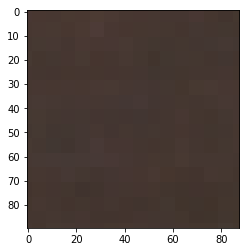

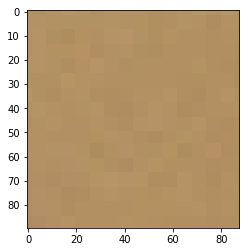

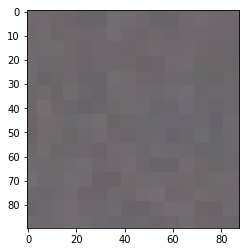

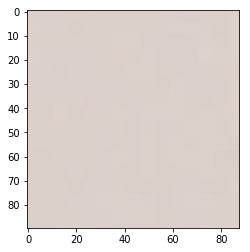

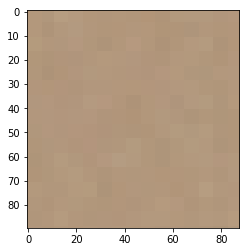

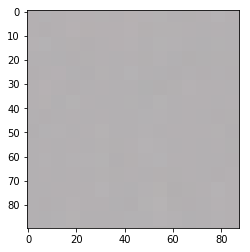

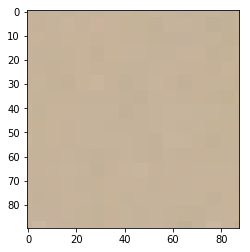

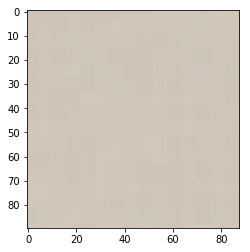

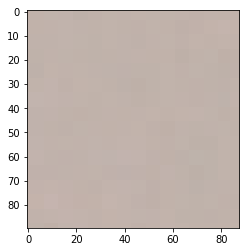

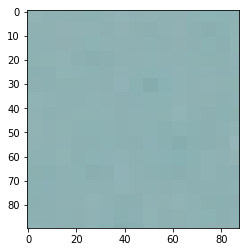

In [590]:
# This output the gt of the training images
for i in range(0, 10):   
    plt.figure(i)
    plt.imshow(res[i])
    
plt.show()

(1200, 1920, 3)


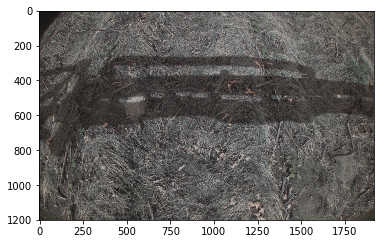

In [591]:
im = cv2.imread('../Research/Shadow/shadow.png')

plt.figure(0)
plt.imshow(im)
print(im.shape)

im = im/255
t_im = torch.tensor(np.asarray(im).reshape(-1, 3)) # this is to do regression on channels

In [592]:
with torch.no_grad():
    predicted = model(t_im.float()).data.numpy()
predicted = predicted.reshape(1200, 1920, 3)

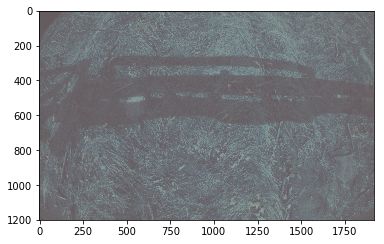

In [593]:
plt.figure(0)
# plt.imshow((predicted * 255).astype(np.uint8))
plt.imshow(predicted)
    
plt.show()